In [222]:
from datacube import read_data
from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing the Models

Use a wildcard and specify the path of the ensemble members for the design value

In [265]:
#PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/daily/processed/hdd/*ann_ta.nc'
#PATH = '/home/nannau/Desktop/ensembles/jan1.0p/*'
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/tas/jul2.5p/*.nc'

Read in ensembles and put in a xarray dataset

In [266]:
ds = read_data(PATH)
dv_field = ds['dv'].values.copy()

tas


load the land mask

In [267]:
mask = load_land_mask('./mask.nc')

Check for any NaN values, and if there are any in the ensemble, disqualify that grid cell from the rest of the analysis. Combine the land mask and the nan mask using `logical disjoint`.


In [268]:
mask_master = mask_land_and_nan(dv_field, mask)

Flatten the master mask into ensemble space to reference the grid cell number that the mask corresponds to. 

In [269]:
idx = mask_land_and_nan_ens_index(mask_master)

Calculate the areas of each grid cell.

In [270]:
area = frac_grid_area(ds['dv'])
area_relevent_grid_cells = area.reshape(1, -1)
area_relevent_grid_cells.shape

(1, 20150)

Flatten the ensemble data cube design values.

In [271]:
ens = ens_flat(ds['dv'].values)

Calculate the mean of each grid cell along the ensemble members.

In [272]:
mean = ens.mean(axis=0).reshape(1, -1)

Weight each design value in the ensemble by its corresponding grid cell area, then subtract the mean of that grid cell across the ensemble. This corresponds to 
$$X' = \left(I_n - \frac{1}{n}1_n\right)X$$
and
$$X'_w = X' W$$
in Chao's methods.

In [273]:
corr_ens = (ens - mean)*area_relevent_grid_cells                                   

The next step is to calculate the first $N$ eof's that explain up to 95% of the variance. Then take only the relavent grid cells by the master mask's ensemble representation, with indices in `idx`

In [274]:
ens_eof = ens_to_eof(corr_ens).components_[:, idx]
print("EOF Shape: ", ens_eof.shape)

EOF Shape:  (27, 9022)


With the fitted EOF pattern, we can take a look at how the EOFs reduce the dimensionality of the ensemble space, by looking at the `explained variance` of each principal component.

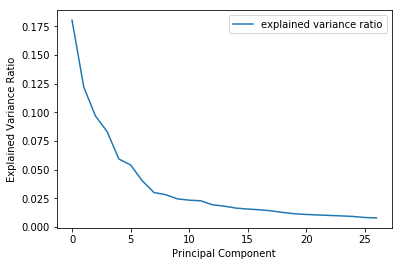

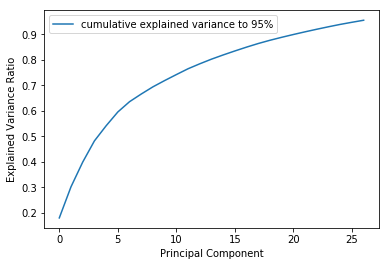

In [275]:
sns.lineplot(range(ens_eof.shape[0]), 
             ens_to_eof(corr_ens).explained_variance_ratio_, 
             label='explained variance ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()
sns.lineplot(range(ens_eof.shape[0]), 
             np.cumsum(ens_to_eof(corr_ens).explained_variance_ratio_),
             label='cumulative explained variance to 95%')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

Extend the rotated latitude and longitude into the ensemble space, assigning a lat and lon to each grid cell in the ensemble array. Also correct the rotated pole configuration into a non-rotated reference frame.

In [276]:
rlon = ds['rlon'].values.copy()
rlat = ds['rlat'].values.copy()
lat, lon = ds['lat'], ds['rlat']

Using the lat(rlon, rlat) and lon(rlon, rlat) grids, look up the corresponding lat and lon in the normal lat and lon projection.

In [277]:
rlon_ens = np.tile(rlon, rlat.shape[0])
rlat_ens = np.repeat(rlat, rlon.shape[0])

lats, lons = [], []

for i in idx:
    lats.append(ds['lat'].sel(rlon=rlon_ens[i], rlat=rlat_ens[i], method='nearest'))
    lons.append(ds['lon'].sel(rlon=rlon_ens[i], rlat=rlat_ens[i], method='nearest'))

In [278]:
# correct for negative lon
lat_ens, lon_ens = np.array(lats), np.array(lons)-360

In [279]:
lat_lon_ens = list(zip(lat_ens, lon_ens))

We are now done with preprocessing the models. 

### Observations

Read in the MSC query observations, and zip together the latitude and longitudes of the stations where the observations were found into a list of tuples representing lat,lon coordinates.

In [300]:
df = pd.read_csv('jan_1st_percentile_1991_2016', index_col=None)

In [301]:
lat_lon_obs = list(zip(df['lat'], df['lon']))
lat_obs, lon_obs = zip(*lat_lon_obs)


Using the euclidean distance, find the _**index location**_ of the grid in the ensemble space that is closest to the observation. Add it to the dataframe. 

Note that this method only tells us which grid cell in the ensemble space is closest to the observation lat, lon. It does not tell us what the actual lat,lon value of that grid cell is.

In [302]:
df['nearest_grid'] = euclidean_dist_index(lat_lon_obs, lat_lon_ens)

If more than one station occupy a CanRCM4 grid cell, take the mean of all of those station's design value.

In [305]:
ndf = df['quantile'].groupby(df['nearest_grid']).mean()

# create an array containing the indices in ensemble space
# of the corresponding observed design values
match_ens_obs_idx = np.asarray(ndf.index)

Weight the observations by area, just like they were weighted in the models. 

$$y_g' = y_g W$$

Only bother with the indices that are matched to the ensemble space.


In [306]:
match_obs_ens = np.array(ndf)*area_relevent_grid_cells[:, match_ens_obs_idx]
match_model_ens = ens_eof[:, match_ens_obs_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)

Check that the observations and the EOFs contain the same number of grids: 
EOF shape:  (27, 831) 
Matched Obs shape:  (831,)


Now regress the matched ensemble array EOFs with the observations, and create a model via least squares regression. Corresponding to the EOFs where $\beta$ and $\epsilon$ are the best fit parameter vectors.
$$y_{g, \perp} = V_{1:k, \perp}\beta+\epsilon$$

In [307]:
model = regress_eof(match_model_ens.T, match_obs_ens[0, :])

Model score: 0.7004846371954352


Now that the model is created, we can use it to reconstruct design values for the rest of the grid cells in the ensemble. 

In [308]:
predictions = predict_dv(model, ens_eof.T)

In [309]:
latlist, lonlist = zip(*list(lat_lon_ens))

Undo the areal weighting, and convert from units of `0.1 deg C` to `deg C` for the matched observations. This corresponds to:
$$y = V_{1:k}\beta W^{-1}$$

In [310]:
observations = .10*match_obs_ens/area_relevent_grid_cells[:, match_ens_obs_idx] 
reconstructed_observations = .10*predictions[match_ens_obs_idx]/area_relevent_grid_cells[:, match_ens_obs_idx]

Predict design values for CanRCM4 grid cells, and compare them with the real observations at those same points.

See how well it compares with a 1:1 relationship.

0.6924688400755602
r2 0.687979315712617
rmse 15.16662876282364


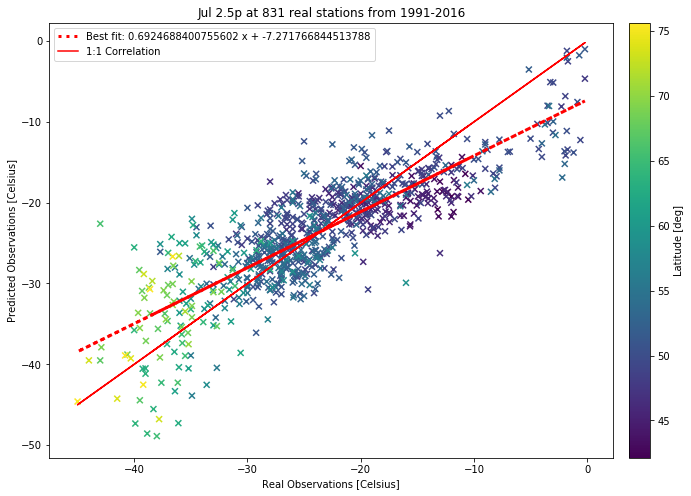

In [312]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print(regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('r2', r2)
print('rmse', rmse)

fig = plt.figure(figsize=(11, 8))
ax = plt.axes()

ax.plot(observations.T[:, 0], 
        y_predicted[:, 0],
        ls=':',
        lw=3,
        color='red',
        label='Best fit: {} x + {}'.format(regression_model.coef_[0][0], 
                                             regression_model.intercept_[0]),
)

cplot = ax.scatter(observations[0, :],
            reconstructed_observations[0, :],
            marker='x', 
            cmap='viridis',
            c=lat_ens[match_ens_obs_idx])

cbar = plt.colorbar(cplot, orientation='vertical',fraction=0.056, pad=0.025)
cbar.ax.set_ylabel('Latitude [deg]')
plt.title('Jul 2.5p at {} real stations from 1991-2016'.format(observations.shape[1]))
ax.plot(observations[0, :], observations[0, :], color='r', label='1:1 Correlation')
plt.legend()
plt.xlabel('Real Observations [Celsius]')
plt.ylabel('Predicted Observations [Celsius]')
plt.savefig('plots/jan_first_predictions_using_obs.pdf')

In [ ]:
# generate pseudo observations from models to 
# compare the reconstruction to real observations with
pseudo_ens_obs, pseudo_idx = generate_pseudo_obs(ens[:, idx], 0.1)

match_obs_ens = pseudo_ens_obs*area_relevent_grid_cells[:, pseudo_idx]
match_model_ens = ens_eof[:, pseudo_idx]

print("Check that the observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', match_model_ens.shape, '\n'
      'Matched Obs shape: ', match_obs_ens[0, :].shape)

print(ens_eof.shape, ens[0, idx].shape, match_model_ens.T.shape, match_obs_ens[0, :].shape)

model = regress_eof(match_model_ens.T, match_obs_ens[0, :])
predictions = predict_dv(model, ens_eof.T)

print(ens_eof.shape, ens.shape)

observations = .10*ens[0, idx]/area_relevent_grid_cells[:, idx]
reconstructed_observations = .10*predictions/area_relevent_grid_cells[:, idx]

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(observations.T, reconstructed_observations.T)

print(regression_model.coef_[0][0])

y_predicted = regression_model.predict(observations.T)
# model evaluation
rmse = mean_squared_error(reconstructed_observations.T, y_predicted)
r2 = r2_score(reconstructed_observations.T, y_predicted)
print('r2', r2)
print('rmse', rmse)

fig = plt.figure(figsize=(11, 8))
ax = plt.axes()
ax.plot(observations.T[:, 0], 
             y_predicted[:, 0],
             label='Best fit: {} x + {}'.format(regression_model.coef_[0][0], 
                                             regression_model.intercept_[0])
)
cplot = ax.scatter(observations[0, :],
            reconstructed_observations[0, :],
            marker='x', 
            cmap='viridis',
            )

#cbar = plt.colorbar(cplot, orientation='vertical',fraction=0.056, pad=0.025)
#cbar.ax.set_ylabel('Latitude [deg]')
plt.title('Correlation using {} pseudo stations'.format(observations.shape[1]))
ax.plot(observations[0, :], observations[0, :], color='r', label='1:1 Correlation')
plt.legend()
plt.xlabel('Real Observations [Celsius]')
plt.ylabel('Predicted Observations [Celsius]')
plt.savefig('plots/first_predictions_using_pseudo_obs.pdf')

Plot the stations used in the regression over top of their closest CanRCM4 grid cell for an instance of the CanRCM4 ensemble.  

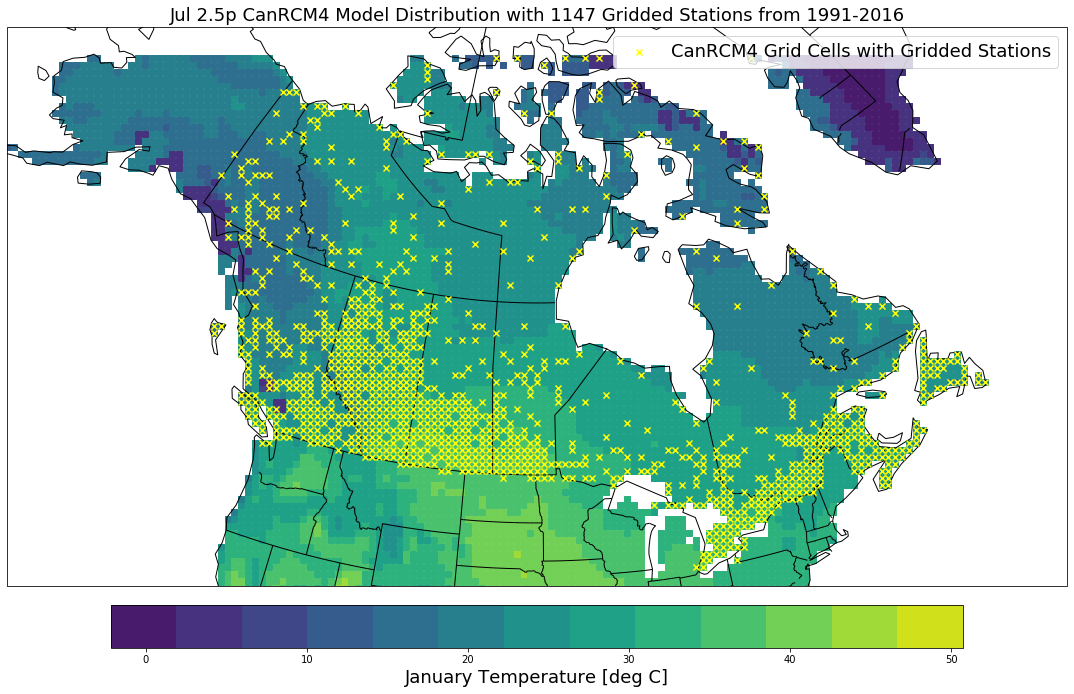

In [297]:
fig = plt.figure(figsize = (19, 14))

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

rp = ccrs.RotatedPole(pole_latitude=42.5, pole_longitude=-97+180)


ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean',
                                                    '10m',
                                                    edgecolor='k',
                                                    facecolor='white')

cmap = mpl.colors.ListedColormap(sns.color_palette("viridis", 13))

# define projections
ax = plt.axes(projection=rp)
ax.coastlines(resolution='110m')
ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(ocean, zorder=0)

cplot = ax.scatter(rlon_ens[idx], 
           rlat_ens[idx],
           c=ens[0, idx],
           transform=rp,
           zorder=1,
           marker='s',
#           alpha=0.85,
           cmap=cmap)

ax.scatter(rlon_ens[idx][match_ens_obs_idx], rlat_ens[idx][match_ens_obs_idx],
                    transform=rp, zorder=2, marker='x', color='yellow',
            label='CanRCM4 Grid Cells with Gridded Stations')

cbar = plt.colorbar(cplot, orientation='horizontal',fraction=0.056, pad=0.025)
cbar.ax.set_xlabel('January Temperature [deg C]', fontsize=18)
# constrain to data
plt.xlim(rlon_ens.min(), rlon_ens.max())
plt.ylim(rlat_ens.min()+23, rlat_ens.max()+2)
plt.title("Jul 2.5p CanRCM4 Model Distribution with {} Gridded Stations from 1991-2016".format(observations.shape[1]), fontsize=18)
plt.legend(fontsize=18)
plt.savefig('plots/jul2.5p_temp_matched_obs.png')
plt.show()
